In [1]:
import numpy as np
from statsmodels.stats.multitest import multipletests
import pandas as pd
import glob
import h5py
import re
from scipy.signal import convolve
from tqdm import tqdm
import scipy.io as sio
import os

import pickle
from matplotlib import pyplot as plt
import matplotlib as mpl
import seaborn as sns
from scipy import stats
from scipy.stats import norm
import tqdm
import itertools

plt.rcParams.update({'font.size': 22})

In [148]:
'''load regression info'''

root_dir = '/dartfs-hpc/scratch/f005d7d/what_where_analysis/'
figure_data_dir = '/dartfs-hpc/rc/home/d/f005d7d/attn-rnn/what_where_analysis/what-where-task-analysis/figures'
processed_path = os.path.join(root_dir, 'processed/')

with open(os.path.join(processed_path, 'all_sess_decoding_info.pkl'), 'rb') as f:
    all_sess_regression_info = pickle.load(f)

with open(os.path.join(processed_path, 'all_sess_cross_decoding_info.pkl'), 'rb') as f:
    all_sess_cross_decoding_info = pickle.load(f)
    
with open(os.path.join(processed_path, 'all_sess_stability_decoding_info.pkl'), 'rb') as f:
    all_sess_stability_decoding_info = pickle.load(f)
    

In [149]:
all_sess_accs = np.stack(all_sess_regression_info['accs'], axis=0).transpose((1,2,0,3))
all_sess_cross_accs = np.stack(all_sess_cross_decoding_info['accs'], axis=0)
all_sess_stability = np.stack(all_sess_stability_decoding_info['accs'], axis=0)
num_timesteps, num_tests, num_sess, num_samples = all_sess_accs.shape

binsize = 0.01
# gauss_SD = 0.02/binsize
win_size = int(0.05/binsize)
stride = int(0.05/binsize)
xxx = np.linspace(-1500, 1500-stride*binsize*1000, num=num_timesteps)



## Decoding accuracies

In [5]:
def plot_mean_se(ax, xxx, yyy, color, linestyle, label, axis):
    mean = yyy.mean(axis)
    se = yyy.std(axis)/np.sqrt(yyy.shape[axis])
    ax.plot(xxx, mean, c=color, ls=linestyle, label=label, lw=3)
    ax.fill_between(xxx, mean-se, mean+se, color=color, alpha=0.2)
    

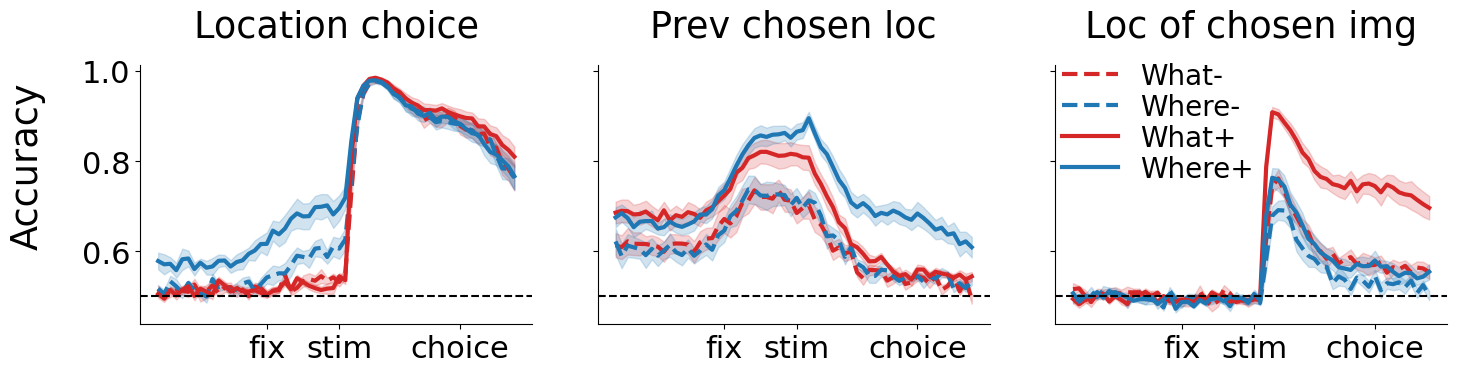

In [6]:
fig, axes = plt.subplots(1,3, figsize=(15, 4.2), sharey=True, sharex=True)

colors = ['tab:red', 'tab:blue']
linestyles = ['--', '-']

block_type_labels=['What', 'Where']
rwd_labels=['-', '+']

for i in range(3):
    curr_test_accs = all_sess_accs[:,i*4:(i+1)*4].mean(-1)
    for idx_rwd in range(2):
        for idx_block_type in range(2):
            plot_mean_se(axes[i], xxx, 
                         curr_test_accs[:,idx_rwd*2+idx_block_type].reshape(num_timesteps, -1),
                         color=colors[idx_block_type], linestyle=linestyles[idx_rwd], 
                         label=block_type_labels[idx_block_type]+rwd_labels[idx_rwd],
                         axis=-1)

axes[-1].legend(bbox_to_anchor=(0.57, 0.45), frameon=False, labelspacing=0.1, fontsize=20)
            
for ax in axes:
    ax.axhline(0.5, ls='--', c='k')
    ax.set_xticks([-600, 0, 1000], ['fix', 'stim', 'choice'])
#     ylims = [0.05-(ax.get_ylim()[1]-0.05)*0.05, ax.get_ylim()[1]]
#     ax.set_ylim(ylims)
#         a.axhline(thresh, ls=':', c='k')
    xlims = ax.get_xlim()
    ax.set_xlim(xlims)

axes[0].set_title('Location choice', pad=20)
axes[1].set_title('Prev chosen loc', pad=20)
axes[2].set_title('Loc of chosen img', pad=20)
        
sns.despine()
fig.supylabel('Accuracy', y=0.55)

fig.tight_layout()





## Cross-decoding accuracy

/scratch/ipykernel_2051243/3586594688.py:30: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=[0, 0, .9, 1])


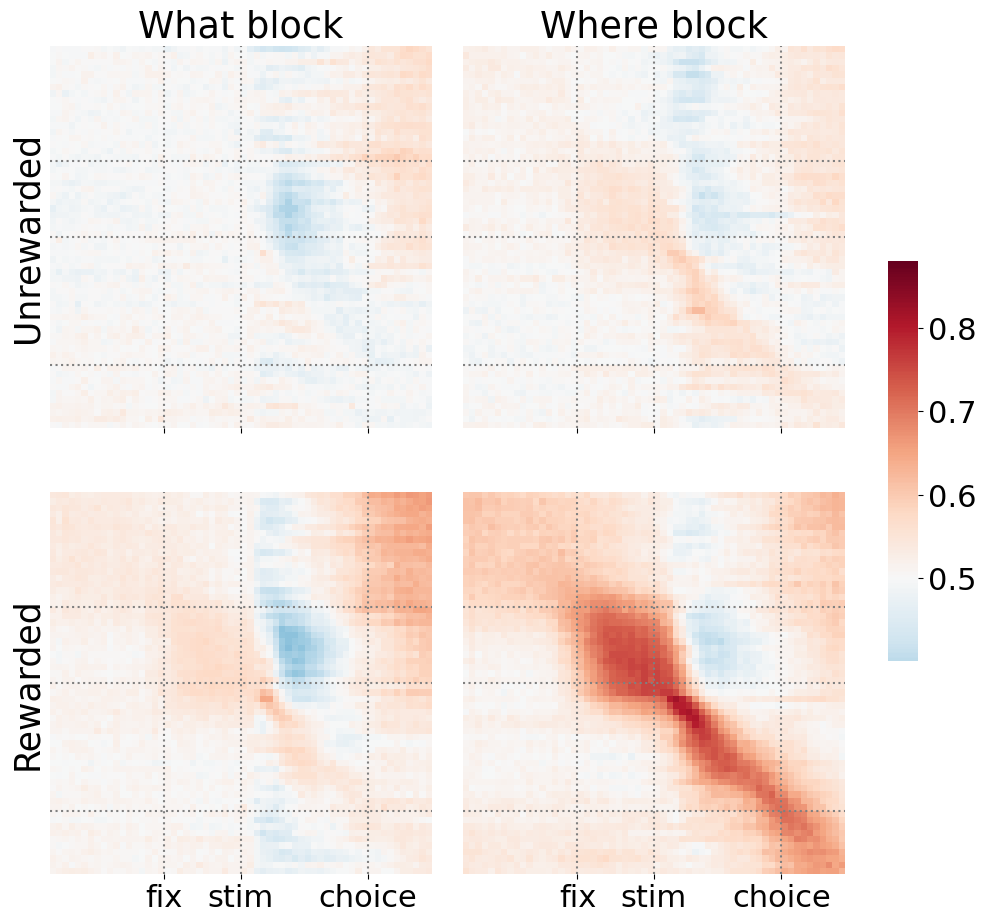

In [150]:
fig, axes = plt.subplots(2,2, figsize=(10, 10), sharex=True)
cbar_ax = fig.add_axes([.91, .3, .03, .4])

for i in range(2):
    for j in range(2):
        acc_no_diag = all_sess_cross_accs[:,:,i*2+j,:,1:2].mean((0,-1))
#         acc_no_diag[np.eye(num_timesteps)>0.5] = np.nan
        sns.heatmap(acc_no_diag, center=0.5, vmax=0.88, cmap='RdBu_r', ax=axes[i,j], 
                    square=True, cbar_ax = cbar_ax if i*2+j==3 else None, 
                    cbar_kws={'shrink': 0.7}, cbar=i*2+j==3)
        
        axes[i,j].axvline(50, ls=':', c='grey')
        axes[i,j].axhline(50, ls=':', c='grey')
        axes[i,j].axvline(30, ls=':', c='grey')
        axes[i,j].axhline(30, ls=':', c='grey')
        axes[i,j].axvline(18, ls=':', c='grey')
        axes[i,j].axhline(18, ls=':', c='grey')
        
        axes[i,j].set_xticks([18, 30, 50], ['fix', 'stim', 'choice'], rotation=0)
        axes[i,j].set_yticks([], [])
        


axes[0,0].set_title('What block')
axes[0,1].set_title('Where block')

axes[0,0].set_ylabel('Unrewarded', fontsize=25)
axes[1,0].set_ylabel('Rewarded', fontsize=25)

fig.tight_layout(rect=[0, 0, .9, 1])
    

/scratch/ipykernel_2051243/3548403614.py:30: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=[0, 0, .9, 1])


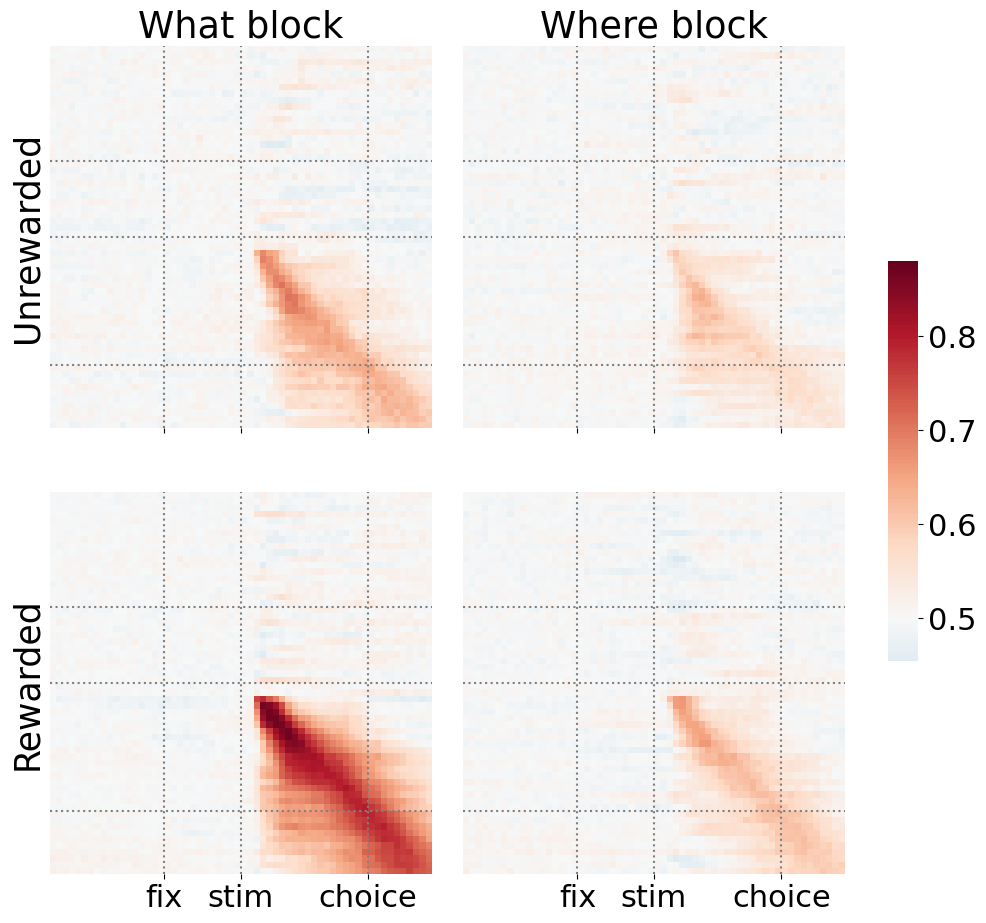

In [151]:
fig, axes = plt.subplots(2,2, figsize=(10, 10), sharex=True)
cbar_ax = fig.add_axes([.91, .3, .03, .4])

for i in range(2):
    for j in range(2):
        acc_no_diag = all_sess_cross_accs[:,:,4+i*2+j,:].mean((0,-1))
#         acc_no_diag[np.eye(num_timesteps)>0.5] = np.nan
        sns.heatmap(acc_no_diag, center=0.5, vmax=0.88, cmap='RdBu_r', ax=axes[i,j], 
                    square=True, cbar_ax = cbar_ax if i*2+j==2 else None, 
                    cbar_kws={'shrink': 0.7}, cbar=i*2+j==2)
        
        axes[i,j].axvline(50, ls=':', c='grey')
        axes[i,j].axhline(50, ls=':', c='grey')
        axes[i,j].axvline(30, ls=':', c='grey')
        axes[i,j].axhline(30, ls=':', c='grey')
        axes[i,j].axvline(18, ls=':', c='grey')
        axes[i,j].axhline(18, ls=':', c='grey')
        
        axes[i,j].set_xticks([18, 30, 50], ['fix', 'stim', 'choice'], rotation=0)
        axes[i,j].set_yticks([], [])
        


axes[0,0].set_title('What block')
axes[0,1].set_title('Where block')

axes[0,0].set_ylabel('Unrewarded', fontsize=25)
axes[1,0].set_ylabel('Rewarded', fontsize=25)

fig.tight_layout(rect=[0, 0, .9, 1])
    

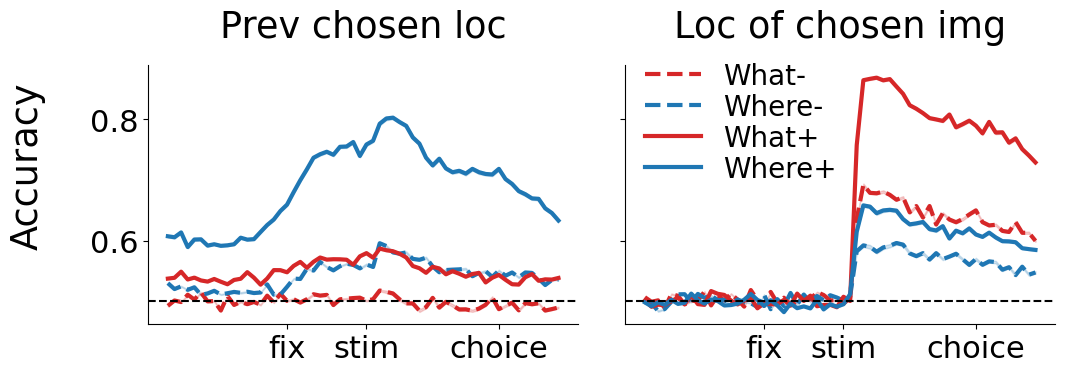

In [152]:
fig, axes = plt.subplots(1,2, figsize=(11, 4.2), sharey=True, sharex=True)

colors = ['tab:red', 'tab:blue']
linestyles = ['--', '-']

block_type_labels=['What', 'Where']
rwd_labels=['-', '+']

for idx_var in range(2):
    curr_test_accs = all_sess_accs[:,i*4:(i+1)*4].mean(-1)
    for idx_rwd in range(2):
        for idx_block_type in range(2):
            acc_diag = np.diagonal(all_sess_cross_accs[:,:,4*idx_var+2*idx_rwd+idx_block_type,:], axis1=1, axis2=2)
            plot_mean_se(axes[idx_var], xxx, 
                         acc_diag.reshape(-1, num_timesteps),
                         color=colors[idx_block_type], linestyle=linestyles[idx_rwd], 
                         label=block_type_labels[idx_block_type]+rwd_labels[idx_rwd],
                         axis=0)

axes[-1].legend(bbox_to_anchor=(0.55, 0.45), frameon=False, labelspacing=0.1, fontsize=20)
            
for ax in axes:
    ax.axhline(0.5, ls='--', c='k')
    ax.set_xticks([-600, 0, 1000], ['fix', 'stim', 'choice'])
#     ylims = [0.05-(ax.get_ylim()[1]-0.05)*0.05, ax.get_ylim()[1]]
#     ax.set_ylim(ylims)
#         a.axhline(thresh, ls=':', c='k')
    xlims = ax.get_xlim()
    ax.set_xlim(xlims)

axes[0].set_title('Prev chosen loc', pad=20)
axes[1].set_title('Loc of chosen img', pad=20)
        
sns.despine()
fig.supylabel('Accuracy', y=0.55)

fig.tight_layout()



## Cross-condition decoding of the same variable

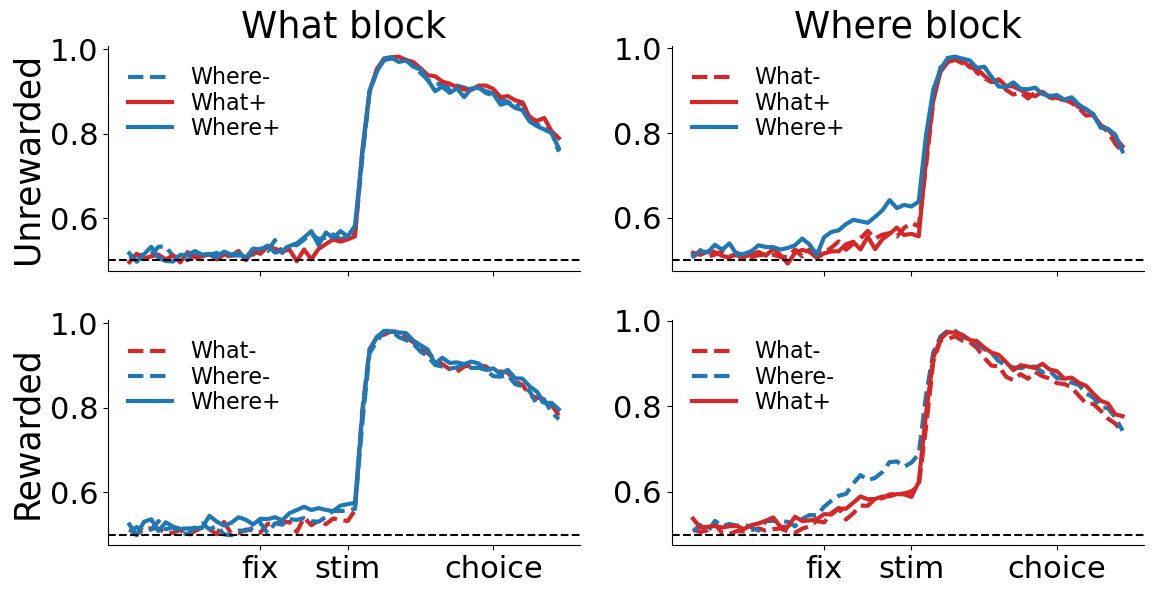

In [153]:
fig, axes = plt.subplots(2, 2, sharex=True,  figsize=(12, 6.4))


for idx_train in range(4):
    conds_tested = np.arange(4)
    conds_tested = conds_tested[conds_tested!=idx_train]
    for true_idx_test, idx_test in enumerate(conds_tested):
        axes[idx_test//2, idx_test%2].plot(xxx, all_sess_stability[:,:,0,idx_train,true_idx_test].mean(0),
                            c=colors[idx_train%2], ls=linestyles[idx_train//2], lw=3,
                            label=block_type_labels[idx_train%2]+rwd_labels[idx_train//2])
        axes[idx_test//2, idx_test%2].legend(loc='upper left', bbox_to_anchor=(0., 1), 
                               frameon=False, labelspacing=0.1, fontsize=16)
        
for ax_row in axes:
    for ax in ax_row:
        ax.axhline(0.5, ls='--', c='k')
        ax.set_xticks([-600, 0, 1000], ['fix', 'stim', 'choice'])
        ylims = [0.5-(ax.get_ylim()[1]-0.5)*0.05, ax.get_ylim()[1]]
        ax.set_ylim(ylims)
#         ax.axhline(thresh, ls=':', c='k')
        xlims = ax.get_xlim()
        ax.set_xlim(xlims)


axes[0,0].set_title('What block')
axes[0,1].set_title('Where block')

axes[0,0].set_ylabel('Unrewarded', fontsize=25)
axes[1,0].set_ylabel('Rewarded', fontsize=25)

sns.despine()
fig.tight_layout()

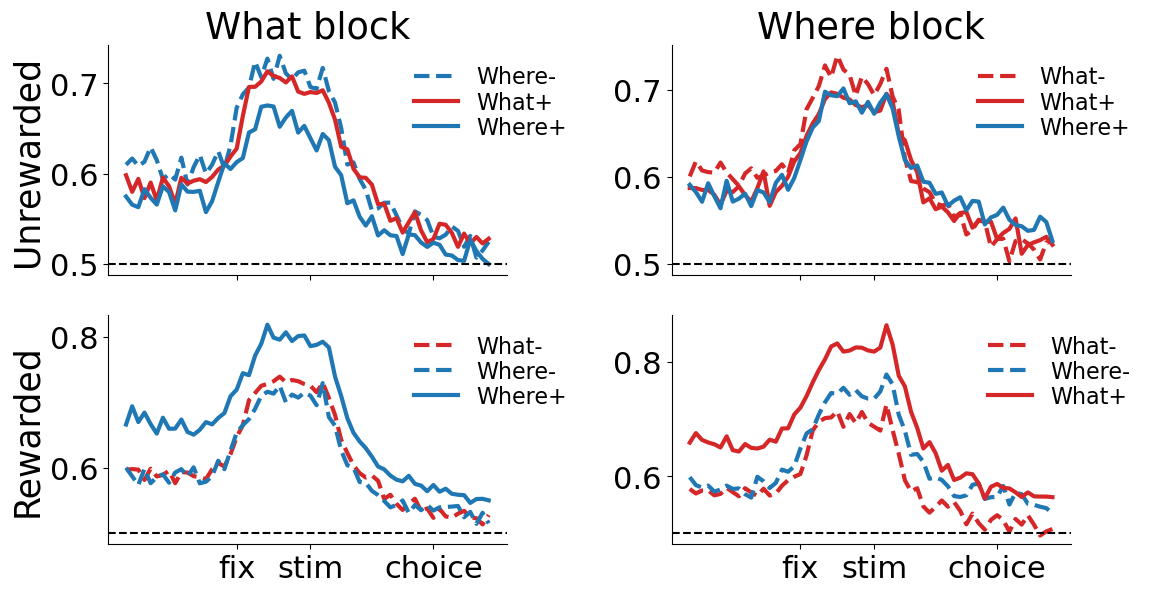

In [154]:
fig, axes = plt.subplots(2, 2, sharex=True, figsize=(12, 6.4))


for idx_train in range(4):
    conds_tested = np.arange(4)
    conds_tested = conds_tested[conds_tested!=idx_train]
    for true_idx_test, idx_test in enumerate(conds_tested):
        axes[idx_test//2, idx_test%2].plot(xxx, all_sess_stability[:,:,1,idx_train,true_idx_test].mean(0),
                            c=colors[idx_train%2], ls=linestyles[idx_train//2], lw=3,
                            label=block_type_labels[idx_train%2]+rwd_labels[idx_train//2])
        axes[idx_test//2, idx_test%2].legend(loc='upper right', bbox_to_anchor=(1.2, 1), 
                               frameon=False, labelspacing=0.1, fontsize=16)
        
        
for ax_row in axes:
    for ax in ax_row:
        ax.axhline(0.5, ls='--', c='k')
        ax.set_xticks([-600, 0, 1000], ['fix', 'stim', 'choice'])
        ylims = [0.5-(ax.get_ylim()[1]-0.5)*0.05, ax.get_ylim()[1]]
        ax.set_ylim(ylims)
    #         a.axhline(thresh, ls=':', c='k')
        xlims = ax.get_xlim()
        ax.set_xlim(xlims)

axes[0,0].set_title('What block')
axes[0,1].set_title('Where block')

axes[0,0].set_ylabel('Unrewarded', fontsize=25)
axes[1,0].set_ylabel('Rewarded', fontsize=25)

sns.despine()
fig.tight_layout()

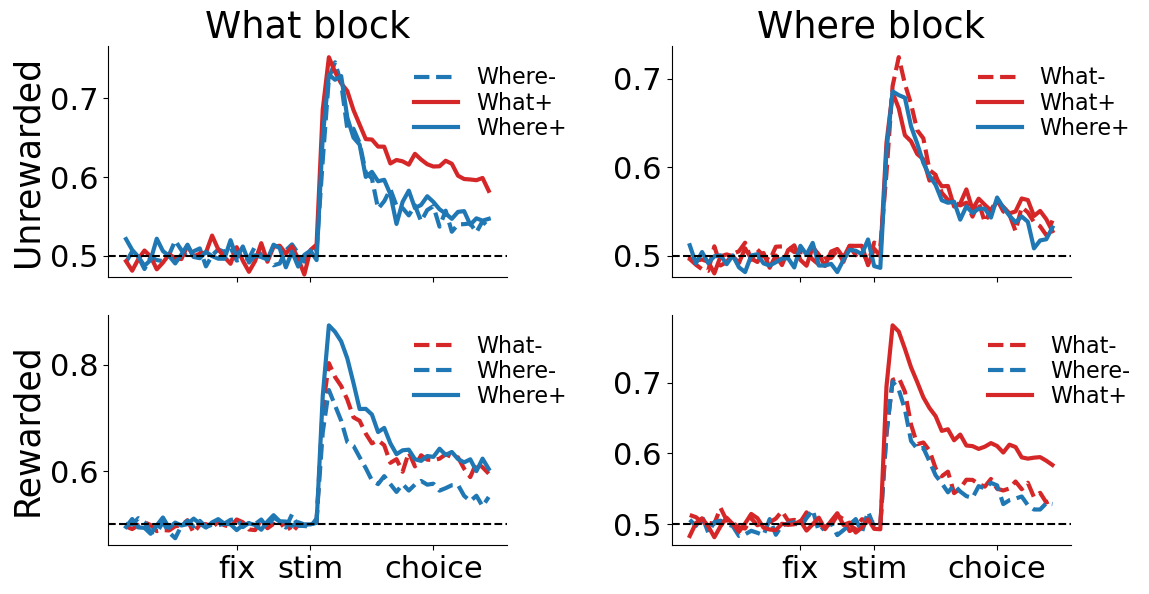

In [155]:
fig, axes = plt.subplots(2, 2, sharex=True,  figsize=(12, 6.4))


for idx_train in range(4):
    conds_tested = np.arange(4)
    conds_tested = conds_tested[conds_tested!=idx_train]
    for true_idx_test, idx_test in enumerate(conds_tested):
        axes[idx_test//2, idx_test%2].plot(xxx, all_sess_stability[:,:,2,idx_train,true_idx_test].mean(0),
                            c=colors[idx_train%2], ls=linestyles[idx_train//2], lw=3,
                            label=block_type_labels[idx_train%2]+rwd_labels[idx_train//2])
        axes[idx_test//2, idx_test%2].legend(loc='upper right', bbox_to_anchor=(1.2, 1.), 
                               frameon=False, labelspacing=0.1, fontsize=16)
        
        
for ax_row in axes:
    for ax in ax_row:
        ax.axhline(0.5, ls='--', c='k')
        ax.set_xticks([-600, 0, 1000], ['fix', 'stim', 'choice'])
        ylims = [0.5-(ax.get_ylim()[1]-0.5)*0.1, ax.get_ylim()[1]]
        ax.set_ylim(ylims)
    #         a.axhline(thresh, ls=':', c='k')
        xlims = ax.get_xlim()
        ax.set_xlim(xlims)


axes[0,0].set_title('What block')
axes[0,1].set_title('Where block')

axes[0,0].set_ylabel('Unrewarded', fontsize=25)
axes[1,0].set_ylabel('Rewarded', fontsize=25)

sns.despine()
fig.tight_layout()